# Solve *Easy21* by Monte Carlo Tree Search

In [1]:
import itertools
from IPython.display import clear_output
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from plot_utils import draw_heatmap
from easy21 import _init, _hit, _stick, HIT, STICK

sns.set()
%matplotlib inline

## Define simulation APIs

Planning methods like tree search requires the simulation capability.  Concretely, the agent needs to *reset* the stating state and *try* many games to evaluate the actions.  The *environment*, which the agent can interact with, is not the ideal platform for this purpose, since it stores states as an internal variable that changes in-place manner. We therefore define the `play` function as below which returns the action outcome from any given state and use it intensively during simulations.

In [2]:
def play(state, action):
    if action == HIT:
        return _hit(state)
    else:
        return _stick(state)

In [3]:
s = _init()
s

(8, 4)

In [4]:
play(s, HIT)

((17, 4), 0.0, False)

In [5]:
play(s, STICK)

((8, 0), 1.0, True)

In [6]:
# number of actions
num_actions = 2
gamma = 1.0

## Monte carlo tree search algorithm

Monte carlo tree search consits of the following four steps: 

* **SELECTION**: Traverse tree by *tree policy* until reaching a new state or terminal state.
* **EXPANSION**: Expand tree with a new state.
* **SIMULATION**: Play *rollout policy* from a given state, and obtain an estimate of the state value.
* **BACKUP**: Traversing backward and revise the state action values.

We store a state and its action values in the concept of node.
We do not store all states in the tree.  This is because the algorithm is often applied to games with large state space, for which full storage is not reasonable or even impossible.

We have two kinds of policies, *tree policy* and *rollout policy*.  We use the tree policy for choosing actions at states within the tree.  Tree policies may use our current value estimates.  A popular tree policy is *Upper-confidence bound for trees* or *UCT*, which chooses the action that maximizes

$$
Q(s, a) + c \sqrt{\frac{2\log N(s)}{N(s,a)}},
$$

where $Q$ is the state-action values and $N$ is the visit counts.  $c$ is a constant controlling the exploration vs exploitation, and often set to one.

When choosing actions at states outiside the tree, we use the rollout policy, which should not depend on the value estimates.  Often, rollout policy is a heuristic decision rule or even completely random choice.

With appreciation of exploration, the tree tends to grow in a shallow (width-first) manner at first, and then  expands more in depth to promising actions.

We can think of many variants of the algorithm by modifying the four steps slightly.  For example, if we traverse down the tree until terminal and expand for all unseen states, then it becomes a monte carlo learning method with a fixed starting state.  We can also expand the tree for states visited more than a few times, say 10.  This controls the condition to switch from rollout to tree policy.  The quality of rollout policy is critical for the success of the algorithm in practice.  If it is near-optimal, then the value estimates are valid monte carlo estimates of the state values from the beginning.

We repeat the four steps for fixed time or iterations. The pseudo code looks as follows.

### $\mathrm{MCTS}(s_0)$:

1. $s, history \leftarrow \mathrm{SelectLeaf}(s_0)$.
1. $\mathrm{ExpandTree}(s)$.
1. $v \leftarrow \mathrm{EvaluateLeaf}(s)$.
1. $\mathrm{UpdateValues}(history, v)$
1. If time allows, go to 1.
1. Return $\mathrm{argmax}_a Q(s_0, a)$.

#### $\mathrm{SelectLeaf}(s):$

1. Initialize $history$ as an empty list.
1. If $s$ is a *new* state or terminal, then return $(s, history)$.
1. Choose an action $a$ based on *tree policy* for $s$.
1. Take the action $a$ and observe $s', r$.
1. Append $(s, a, r)$ to $history$.
1. Set $s \leftarrow s'$ and go to 2.


#### $\mathrm{ExpandTree}(s):$

1. Add $s$ to the tree, and initialize $Q(s, a) \leftarrow 0$ for all action $a$.


#### $\mathrm{EvaluateLeaf}(s):$

1. Set $v \leftarrow 0$, $t \leftarrow 0$
1. If $s$ is terminal, return $v$.
1. Set $t \leftarrow t + 1$.
1. Choose an action $a$ based on *rollout policy* for $s$.
1. Take the action $a$ and observe $s', r$.
1. Set $v \leftarrow v + \gamma^t r$.
1. Set $s \leftarrow s'$ and go to 1.


#### $\mathrm{UpdateValues}(history, v):$

1. Pop $(s, a, r)$ from the bottom of $history$.
2. Set $v \leftarrow r + \gamma v$, 
$$
  Q(s, a) \leftarrow Q(s, a) + \alpha (v - Q(s, a))
$$
3. If $history$ is not empty, go to 1.

In [7]:
def mcts_episode(s0, qs, ns, gamma, tree_policy, rollout_policy):
    s, history, done = select_leaf(s0, qs, ns, tree_policy)
    if not done:
        expand_tree(s, qs, ns)
    v = 0.0 if done else evaluate_leaf(s, gamma, rollout_policy)
    update_values(history, v, gamma, qs, ns)

def tree_policy(s, qs, ns):
    uct = qs[s] + np.sqrt(2 * math.log(np.sum(ns[s]) + 1) / (ns[s] + 1e-4))
    return np.argmax(uct)

def select_leaf(s0, qs, ns, tree_policy):
    # assume: s0 is not terminal
    history = []
    s, done = s0, False
    while True:
        if s not in qs or done:
            return s, history, done
        action = tree_policy(s, qs, ns)
        s1, r, done = play(s, action)
        history.append((s, action, r))
        s = s1

def expand_tree(s, qs, ns):
    if s not in qs:
        qs[s] = np.zeros(num_actions)
        ns[s] = np.zeros(num_actions)

def evaluate_leaf(s, gamma, rollout_policy):
    # assume: s is not terminal
    v, t, done = 0.0, 0.0, False
    while True:
        action = rollout_policy(s)
        s1, r, done = play(s, action)
        t += 1
        v += r * (gamma**t)
        if done:
            return v
        s = s1

def update_values(history, v, gamma, qs, ns):
    for s, a, r in reversed(history):
        v = r + gamma*v
        ns[s][a] += 1.0
        qs[s][a] += (v - qs[s][a]) / ns[s][a]

## Random rollout policy

We will make experiment with random rollout policy.  We set two arbitrary states and see how MCTS algorithm makes a decision.
With $s_0 = (18, 5)$, where the current number is high enough, we should choose "Stick".

The MCTS tends to choose the right action (Not always, though).  Note that $N$ is also high for the right action, since it is chosen more by the tree policy.

In [8]:
def random_policy(s):
    return random.randint(0, num_actions)

qs = {}
ns = {}
s0 = (18, 5)  # with this high current number, stick should be the better choice
print("Initial state:", s0)
for t in tqdm(range(100)):
    mcts_episode(s0, qs, ns, gamma, tree_policy, random_policy)
print("Q, N =", qs[s0], ns[s0])

Initial state: (18, 5)


C:\Users\DEBTIR~1\AppData\Local\Temp/ipykernel_14912/4292312918.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for t in tqdm(range(100)):


  0%|          | 0/100 [00:00<?, ?it/s]

Q, N = [ 0.47916667 -1.        ] [96.  3.]


## Compare to the DP result

We will compare the result against the DP result, which we assume is "correct".  To do this, we iterate over all possible state $s_0$, and estimate the Q-value using the MCTS and derive the optimal policy.  Note that this is not what we do with MCTS in practice; It is a method to make decision for a certain state, not to estimate the values for all states.

We initialize qs and ns at the beginning of each state for the sake of fair comparison across states.  In practice, reuse of the estimated Q-values will help faster convergence.

In [9]:
f = np.load("result/dp.npz")
Q_dp = f["Q"]
policy_dp = f["pi"] 
q_diff_dp = Q_dp[:,:,1] - Q_dp[:,:,0]

q_diff_dp.shape, policy_dp.shape

((21, 10), (21, 10))

In [10]:
# Number of search
# we keep this small in this experiment, since the state space is small for this game,
# if we search enough, all states are visited, after which 
# the algorithm does not depend on the rollout policy.
num_iter = 2000

C:\Users\DEBTIR~1\AppData\Local\Temp/ipykernel_14912/1376505945.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(itertools.product(range(1, 22), range(1, 11)), total=21*10):


  0%|          | 0/210 [00:00<?, ?it/s]

Fraction of "correct" action = 88.10%


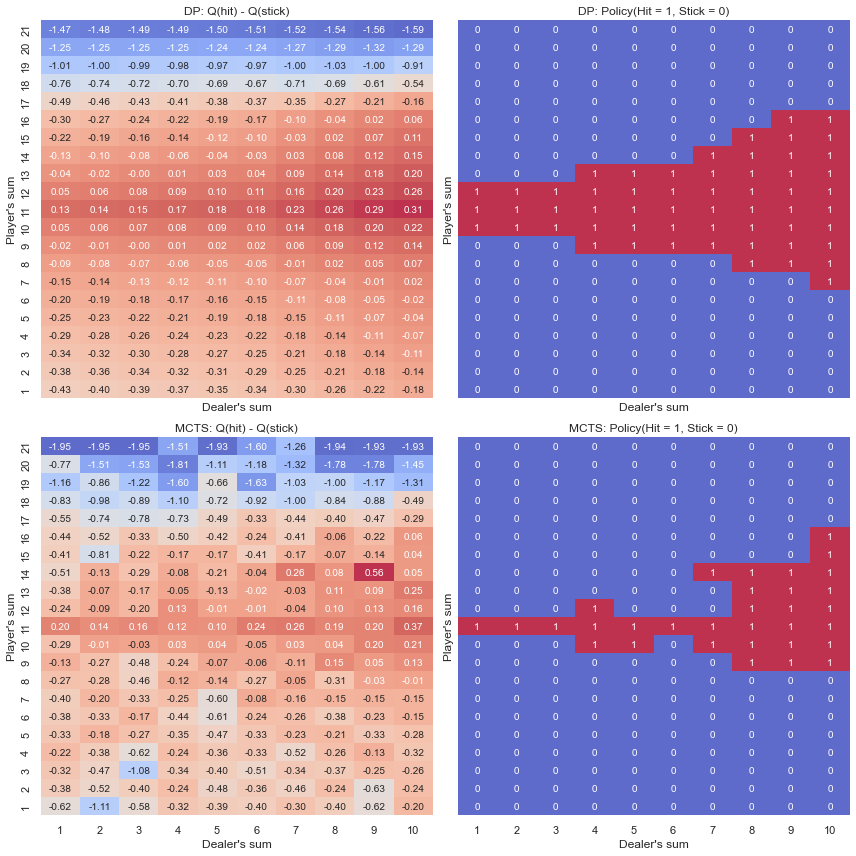

In [11]:
q_value = np.empty((22, 11, 2))
for s in tqdm(itertools.product(range(1, 22), range(1, 11)), total=21*10):  
    qs = {}
    ns = {}
    for t in range(num_iter):
        mcts_episode(s, qs, ns, gamma, tree_policy, random_policy)
    q_value[s] = qs[s]

q_diff = q_value[:,:,1] - q_value[:,:,0]
policy = np.argmax(q_value, axis=-1)

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
# DP
draw_heatmap(q_diff_dp, ax=axes[0,0], title="DP: Q(hit) - Q(stick)")
draw_heatmap(policy_dp, ax=axes[0,1], title="DP: Policy(Hit = 1, Stick = 0)", fmt="d")
# mcts
draw_heatmap(q_diff[1:, 1:], ax=axes[1,0], title="MCTS: Q(hit) - Q(stick)")
draw_heatmap(policy[1:, 1:], ax=axes[1,1], title="MCTS: Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()

print('Fraction of "correct" action = %.2f%%' % (100 * np.mean(policy[1:, 1:] == policy_dp)))

*Remark: The resulted policy is surprisingly good.  Since the state space is not so large for this game, the algorithm searches exhaustively with enough iterations, after which the algorithm is equivalent to the monte carlo control method.*

## "Stick-to-stick" rollout policy

In the *easy21* game, hit is a risky action since one may bust with high as well as low numbers.  Also, since dealer plays rather randomly in this setup, sticking to "stick" is not a bad idea (just wish the dealer gets bust).  We therefore see if using this as the rollout policy improves the decision.

C:\Users\DEBTIR~1\AppData\Local\Temp/ipykernel_14912/2847237811.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(itertools.product(range(1, 22), range(1, 11)), total=21*10):


  0%|          | 0/210 [00:00<?, ?it/s]

Fraction of "correct" action = 88.57%


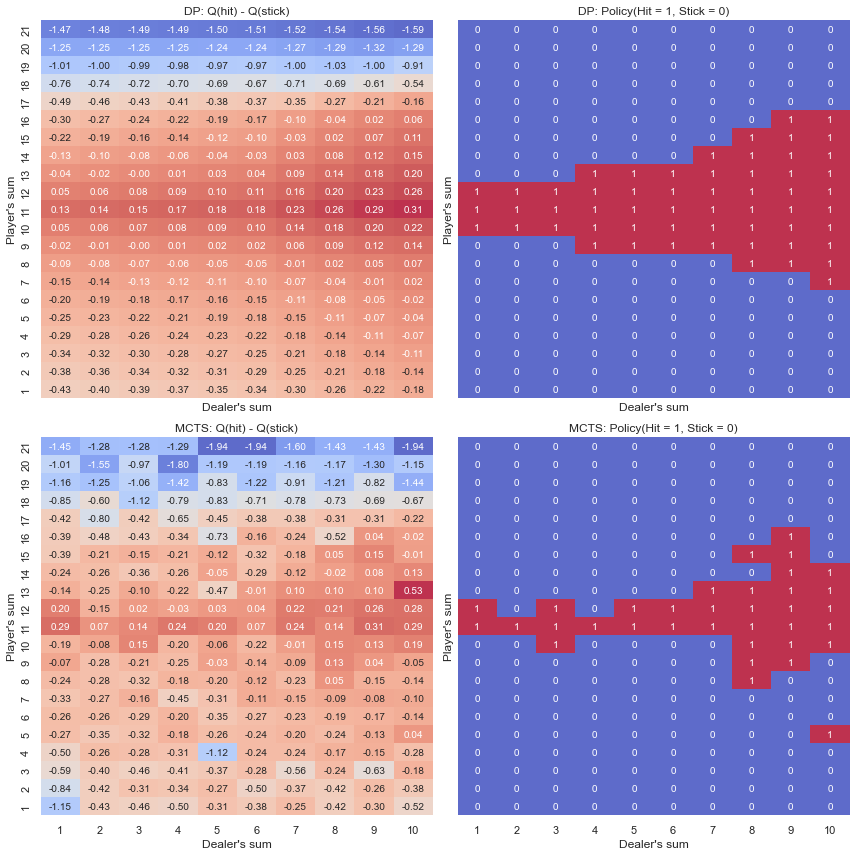

In [12]:
def always_stick_policy(s):
    return STICK

q_value = np.empty((22, 11, 2))
for s in tqdm(itertools.product(range(1, 22), range(1, 11)), total=21*10):  
    qs = {}
    ns = {}
    for t in range(num_iter):
        mcts_episode(s, qs, ns, gamma, tree_policy, always_stick_policy)
    q_value[s] = qs[s]

q_diff = q_value[:,:,1] - q_value[:,:,0]
policy = np.argmax(q_value, axis=-1)

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
# DP
draw_heatmap(q_diff_dp, ax=axes[0,0], title="DP: Q(hit) - Q(stick)")
draw_heatmap(policy_dp, ax=axes[0,1], title="DP: Policy(Hit = 1, Stick = 0)", fmt="d")
# mcts
draw_heatmap(q_diff[1:, 1:], ax=axes[1,0], title="MCTS: Q(hit) - Q(stick)")
draw_heatmap(policy[1:, 1:], ax=axes[1,1], title="MCTS: Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()

print('Fraction of "correct" action = %.2f%%' % (100 * np.mean(policy[1:, 1:] == policy_dp)))

## "Stick-to-hit" rollout policy

We try an unintuitive policy where we always "stick" during the rollout.

C:\Users\DEBTIR~1\AppData\Local\Temp/ipykernel_14912/2352967238.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(itertools.product(range(1, 22), range(1, 11)), total=21*10):


  0%|          | 0/210 [00:00<?, ?it/s]

Fraction of "correct" action = 80.00%


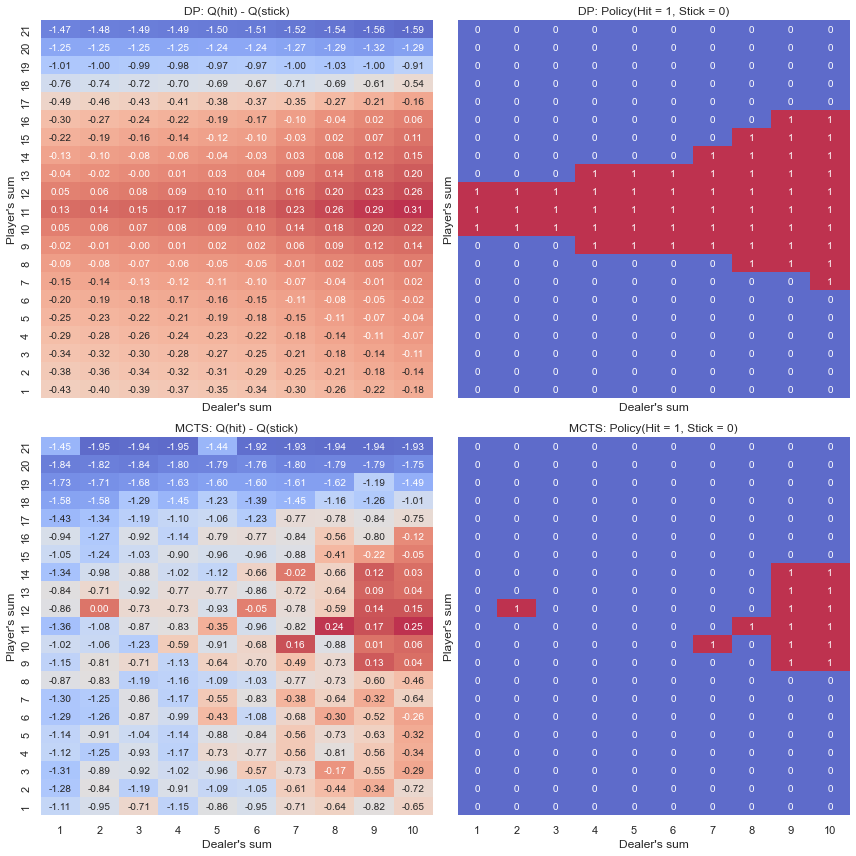

In [13]:
def always_hit_policy(s):
    return HIT

q_value = np.empty((22, 11, 2))
for s in tqdm(itertools.product(range(1, 22), range(1, 11)), total=21*10):  
    qs = {}
    ns = {}
    for t in range(num_iter):
        mcts_episode(s, qs, ns, gamma, tree_policy, always_hit_policy)
    q_value[s] = qs[s]

q_diff = q_value[:,:,1] - q_value[:,:,0]
policy = np.argmax(q_value, axis=-1)

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
# DP
draw_heatmap(q_diff_dp, ax=axes[0,0], title="DP: Q(hit) - Q(stick)")
draw_heatmap(policy_dp, ax=axes[0,1], title="DP: Policy(Hit = 1, Stick = 0)", fmt="d")
# mcts
draw_heatmap(q_diff[1:, 1:], ax=axes[1,0], title="MCTS: Q(hit) - Q(stick)")
draw_heatmap(policy[1:, 1:], ax=axes[1,1], title="MCTS: Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()

print('Fraction of "correct" action = %.2f%%' % (100 * np.mean(policy[1:, 1:] == policy_dp)))

## Threshold rollout policy

We also consider a slightly more sophicticated policy; Hit when the risk is not so high, *i.e.* current number if close to 11.  While optimal policy should also take dealer's card into account as well, this is not so far from the optimal decision rule derived by the dynamic programming.  We will use this as a rollout policy and see if the result improves.

C:\Users\DEBTIR~1\AppData\Local\Temp/ipykernel_14912/3456913317.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(itertools.product(range(1, 22), range(1, 11)), total=21*10):


  0%|          | 0/210 [00:00<?, ?it/s]

Fraction of "correct" action = 90.95%


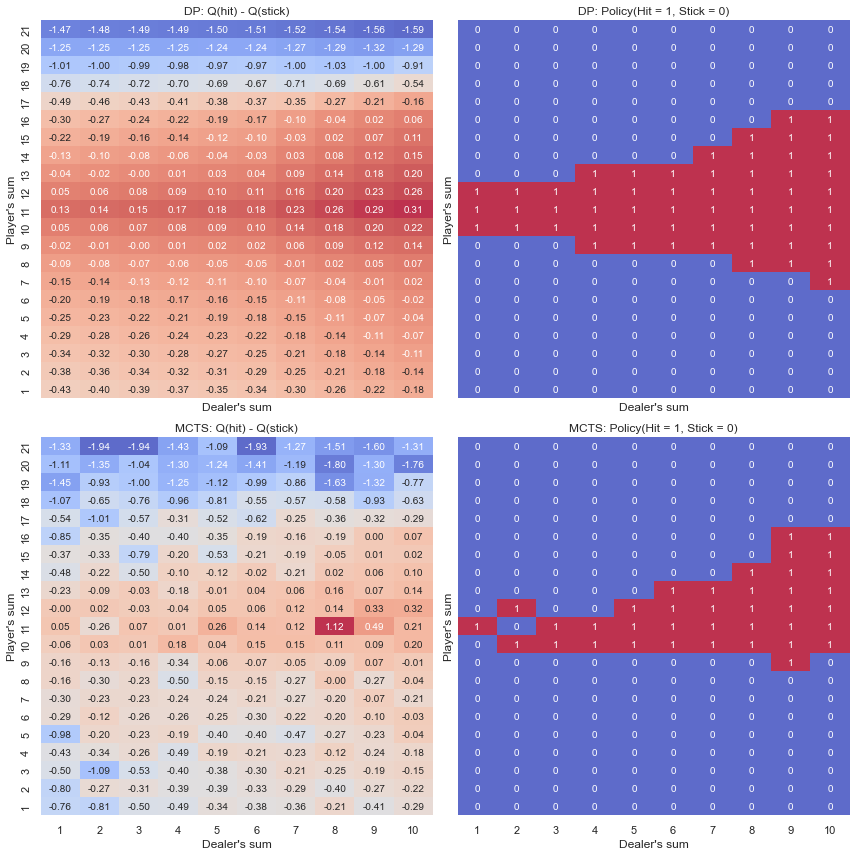

In [14]:
def threshold_rollout_policy(s, ub=16, lb=7):
    return (HIT if s[0] <= ub and s[0] >= lb else STICK)

q_value = np.empty((22, 11, 2))
for s in tqdm(itertools.product(range(1, 22), range(1, 11)), total=21*10):  
    qs = {}
    ns = {}
    for t in range(num_iter):
        mcts_episode(s, qs, ns, gamma, tree_policy, threshold_rollout_policy)
    q_value[s] = qs[s]

q_diff = q_value[:,:,1] - q_value[:,:,0]
policy = np.argmax(q_value, axis=-1)

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
# DP
draw_heatmap(q_diff_dp, ax=axes[0,0], title="DP: Q(hit) - Q(stick)")
draw_heatmap(policy_dp, ax=axes[0,1], title="DP: Policy(Hit = 1, Stick = 0)", fmt="d")
# mcts
draw_heatmap(q_diff[1:, 1:], ax=axes[1,0], title="MCTS: Q(hit) - Q(stick)")
draw_heatmap(policy[1:, 1:], ax=axes[1,1], title="MCTS: Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()

print('Fraction of "correct" action = %.2f%%' % (100 * np.mean(policy[1:, 1:] == policy_dp)))

## Myopic rollout policy

We try another version of the rollout policy where hit is chosen if the player is currently "losing", *i.e.* current player's card is smaller than dealer's.  This is not a good strategy since it completely ignores the possibility of bust, but we see how this works.

C:\Users\DEBTIR~1\AppData\Local\Temp/ipykernel_14912/3116717403.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(itertools.product(range(1, 22), range(1, 11)), total=21*10):


  0%|          | 0/210 [00:00<?, ?it/s]

Fraction of "correct" action = 89.52%


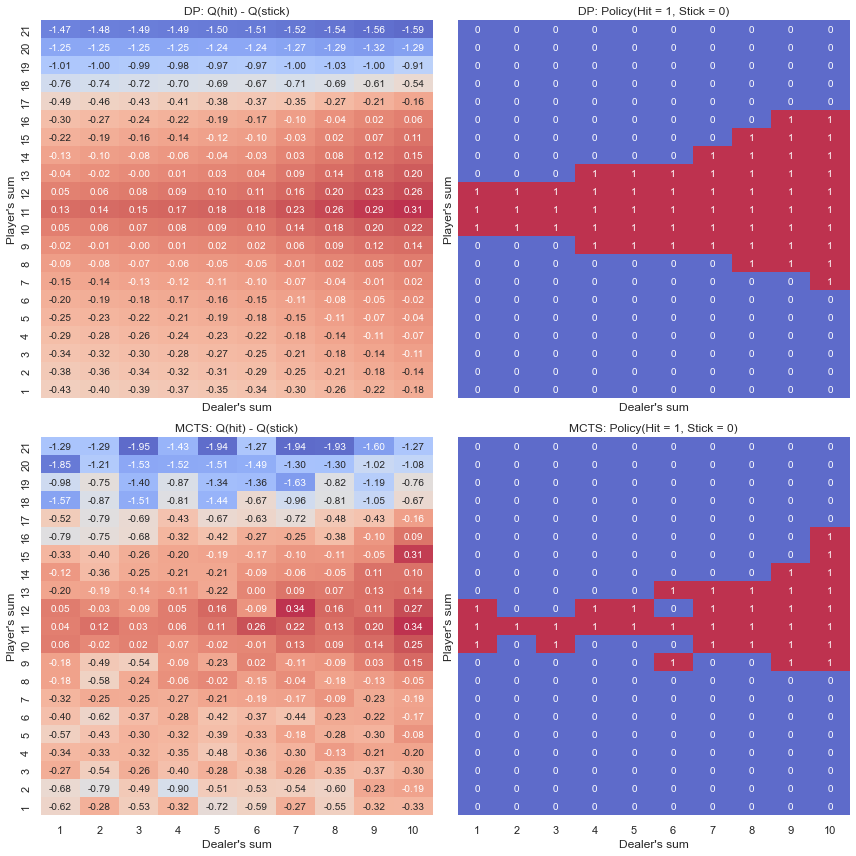

In [15]:
def myopic_rollout_policy(s):
    return HIT if s[0] < s[1] else STICK

q_value = np.empty((22, 11, 2))
for s in tqdm(itertools.product(range(1, 22), range(1, 11)), total=21*10):  
    qs = {}
    ns = {}
    for t in range(num_iter):
        mcts_episode(s, qs, ns, gamma, tree_policy, myopic_rollout_policy)
    q_value[s] = qs[s]

q_diff = q_value[:,:,1] - q_value[:,:,0]
policy = np.argmax(q_value, axis=-1)

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
# DP
draw_heatmap(q_diff_dp, ax=axes[0,0], title="DP: Q(hit) - Q(stick)")
draw_heatmap(policy_dp, ax=axes[0,1], title="DP: Policy(Hit = 1, Stick = 0)", fmt="d")
# mcts
draw_heatmap(q_diff[1:, 1:], ax=axes[1,0], title="MCTS: Q(hit) - Q(stick)")
draw_heatmap(policy[1:, 1:], ax=axes[1,1], title="MCTS: Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()

print('Fraction of "correct" action = %.2f%%' % (100 * np.mean(policy[1:, 1:] == policy_dp)))

## "Optimal" rollout policy

Finally, we use the optimal policy, deribed by the dynamic programming, as the rollout policy.  Theoretically, this is the ideal rollout policy, which is not available in practice.  We will see if this brings a good outcome.

C:\Users\DEBTIR~1\AppData\Local\Temp/ipykernel_14912/2150555988.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(itertools.product(range(1, 22), range(1, 11)), total=21*10):


  0%|          | 0/210 [00:00<?, ?it/s]

Fraction of "correct" action = 89.52%


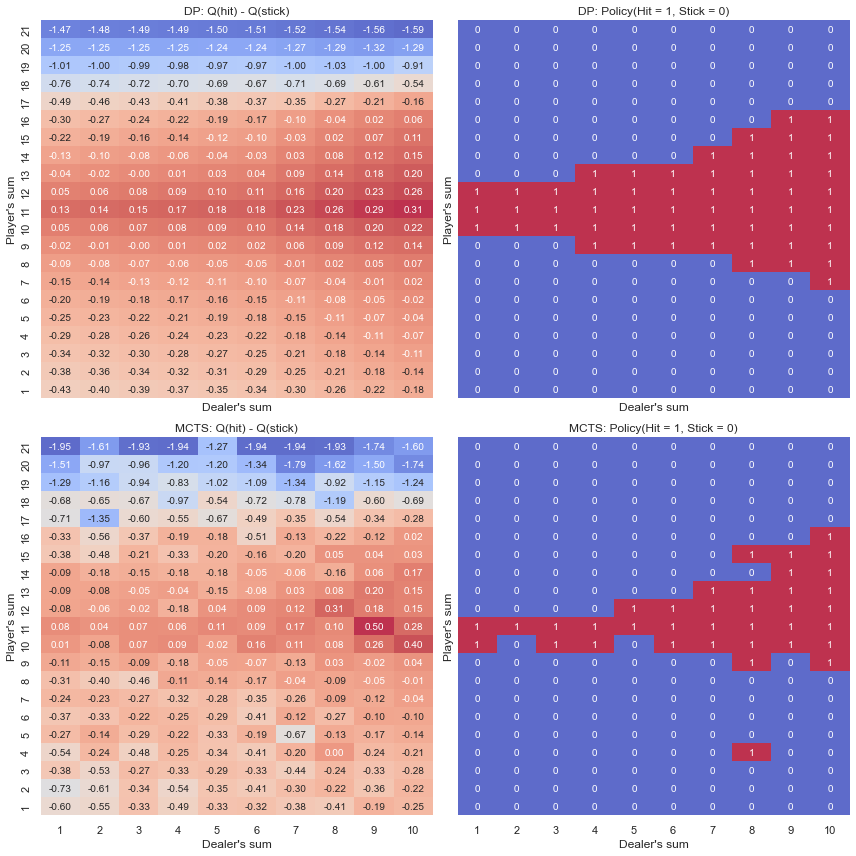

In [16]:
def optimal_rollout_policy(s):
    return policy_dp[s[0]-1, s[1]-1]

q_value = np.empty((22, 11, 2))
for s in tqdm(itertools.product(range(1, 22), range(1, 11)), total=21*10):  
    qs = {}
    ns = {}
    for t in range(num_iter):
        mcts_episode(s, qs, ns, gamma, tree_policy, optimal_rollout_policy)
    q_value[s] = qs[s]

q_diff = q_value[:,:,1] - q_value[:,:,0]
policy = np.argmax(q_value, axis=-1)

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
# DP
draw_heatmap(q_diff_dp, ax=axes[0,0], title="DP: Q(hit) - Q(stick)")
draw_heatmap(policy_dp, ax=axes[0,1], title="DP: Policy(Hit = 1, Stick = 0)", fmt="d")
# mcts
draw_heatmap(q_diff[1:, 1:], ax=axes[1,0], title="MCTS: Q(hit) - Q(stick)")
draw_heatmap(policy[1:, 1:], ax=axes[1,1], title="MCTS: Policy(Hit = 1, Stick = 0)", fmt="d")
fig.tight_layout()

print('Fraction of "correct" action = %.2f%%' % (100 * np.mean(policy[1:, 1:] == policy_dp)))

*Remark: Except that "Always-Hit" rollout policy is clearly inferior, we do not see significant difference across rollout policies.  Random rollout works reasonablly well, and the "correct" rollout gets about equally good outcome.*